# 일반화 성능

## 1.환경준비

### (1) import

In [1]:
#라이브러리들을 불러오자.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 전처리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 모델링
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import * 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import warnings    # 경고메시지 제외
warnings.filterwarnings(action='ignore')

### (2) 데이터 준비

* 변수설명
    * COLLEGE : 대학 졸업여부
    * INCOME : 연수입
    * OVERAGE : 월평균 초과사용 시간(분)
    * LEFTOVER : 월평균 잔여시간비율(%)
    * HOUSE : 집값
    * HANDSET_PRICE : 스마트폰 가격
    * OVER_15MINS_CALLS_PER_MONTH : 월평균 장기통화(15분이상) 횟수
    * AVERAGE_CALL_DURATION : 평균 통화 시간
    * REPORTED_SATISFACTION : 만족도 설문조사 결과
    * REPORTED_USAGE_LEVEL : 사용도 자가진단 결과
    * CONSIDERING_CHANGE_OF_PLAN : 향후 변경계획 설문조사 결과
    * CHURN : 이탈(번호이동) 여부 (1-이탈, 0-잔류, Target 변수)


In [2]:
# 데이터를 불러옵시다.
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/mobile_cust_churn.csv'
data = pd.read_csv(path)
data = data.sample(1000, random_state = 2022)
data['CHURN'] = data['CHURN'].map({'LEAVE':1, 'STAY':0}) #stats 모델의 logit 함수때문에
data.head()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
3178,3179,0,119512,51,31,248566,229,5,2,very_sat,very_high,considering,1
14926,14927,1,142144,192,15,774317,581,29,4,unsat,very_little,never_thought,1
15116,15117,1,142308,0,79,306426,497,1,1,sat,little,considering,0
12733,12734,1,113385,0,0,333599,819,1,6,very_unsat,very_high,considering,1
14032,14033,1,90348,209,10,637286,360,26,4,unsat,little,actively_looking_into_it,0


## 2.데이터 준비

### (1) 데이터 정리

In [3]:
drop_cols = ['id']
data.drop(drop_cols, axis = 1, inplace = True )

### (2) 데이터분할1 : x, y 나누기

In [4]:
target = 'CHURN'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

### (3) NA 조치

### (4) 가변수화

In [5]:
dumm_cols = ['REPORTED_SATISFACTION','REPORTED_USAGE_LEVEL','CONSIDERING_CHANGE_OF_PLAN']
x = pd.get_dummies(x, columns = dumm_cols, drop_first = True)

## 3.Random Sampling

* 데이터를 랜덤에서 분할하여 모델링 & 예측을 여러번 반복적으로 수행합니다.


### (1) 아래 셀을 반복 실행해 봅시다.


In [6]:
# 데이터 분할
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2)

# DecisionTree 모델링
model = DecisionTreeClassifier(max_depth = 3)
model.fit(x_train, y_train)
pred = model.predict(x_val)
accuracy_score(y_val, pred)
# 0.6 ~ 0.745 이런식으로 다 다르게 나옴 (왜냐? 랜덤하게 쪼갰으니까)
# variance가 엄청나게 범위가 넓음.

0.67

정분류율은 몇 인가요?  
값이 달라지나요? 값이 달라지는 원인은 무엇인가요?   
값이 달라진다면 모델의 성능을 어떻게 믿을 수 있을까요?  

### (2) 여러번 반복해서 평균을 계산해 봅시다.

In [7]:
# 100번 반복 실행하여 결과를 담아 냅시다.

result = []
for i in range(100):
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2)

    model = DecisionTreeClassifier(max_depth = 3)
    model.fit(x_train, y_train)
    pred = model.predict(x_val)
    result.append(accuracy_score(y_val, pred))

평균과 표준편차를 구해 봅시다.

In [8]:
np.mean(result), np.std(result)
#아까는 0.6~0.745였는데
# 평균내니까 0.67, 0.68 내외로 다 모임

(0.6820499999999999, 0.03085526697340341)

값의 분포를 살짝 살펴보면

mean: 0.6820499999999999 ,  std: 0.03085526697340341


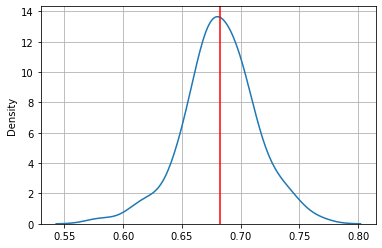

In [9]:
print('mean:', np.mean(result), ',  std:', np.std(result))
sns.kdeplot(result)
plt.axvline(np.mean(result), color = 'r')
plt.grid()
plt.show()

# 빨간 선 : 평균
# 100번 수행한 결과가 정규분포 모양이 나옴.
# 한 번 나온 결과 믿으면 안되고, 여러번 수행 후 평균을 이야기 해야 함.
# 튜닝할 때도 여러 번 수행하고 평균으로 이야기 해야함.
# 튜닝 -> 여러 개 수행하고 평균낸 걸로 가져옴

### (3) 실습 : knn 알고리즘으로 실습해 봅시다.

k를 지정하지 말고(default)로 100회 수행한 후 결과를 담고 평균으로 일반화 성능을 얻어 봅시다.

In [ ]:
# 100번 반복 실행하여 결과를 담아 냅시다.


## 4.k-fold Cross Validation

계획적으로 분할, 학습, 검증하는 방식을 사용해 봅시다!


### (1) cross_val_score 함수 불러오기

* cross validation 함수를 이용하여 모델을 검증합니다.

In [10]:
# 필요한 패키지, 함수 로딩
from sklearn.model_selection import cross_val_score

### (2) 모델링 및 검증

In [11]:
# 모델 선언 
model = DecisionTreeClassifier(max_depth = 3)

* cross_val_score(모델, x, y, cv)
    * 여기에서 x, y는 train + val 

In [12]:
# train + validation set을 이용하여 학습, 예측, 평가를 한번에. (여기서는 .fit 이 아님!)
dt_result = cross_val_score(model, x, y, cv=10)
print(dt_result)
print(dt_result.mean(), dt_result.std())

# 다른 사람들과 비교해봤을 때 평균이 다 비슷
# 랜덤하게 돌렸을 때는 평균이 좀 들쑥날쑥했었음
# 하지만 편차는 아까에 비해 좀 크다

[0.66 0.73 0.64 0.68 0.66 0.72 0.63 0.69 0.61 0.73]
0.675 0.040311288741492736


### (3) 실습 : knn알고리즘을 이용하여 k-fold cv 수행
knn알고리즘으로 10-fold cv를 수행해 봅시다.

In [22]:
# scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_s = scaler.fit_transform(x)

In [25]:
model2 = KNeighborsClassifier()
res = cross_val_score(model2, x_s, y, cv=10) #모델이 10번 돌아감
#보통 cv는 5-10 정도 사이에서 사용한다고 함

In [26]:
print(res)
print(res.mean(), res.std())

[0.58 0.59 0.62 0.59 0.52 0.58 0.57 0.63 0.54 0.59]
0.581 0.03112876483254675


## 5.데이터 늘리기(Learning Curve)

### (1) 데이터 준비
데이터의 양을 조금 늘려 놓고 수행하겠습니다.

In [27]:
# 데이터를 불러옵시다.
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/mobile_cust_churn.csv'
data = pd.read_csv(path)
data = data.sample(4000, random_state = 2022)
data['CHURN'] = data['CHURN'].map({'LEAVE':1, 'STAY':0})

In [28]:
drop_cols = ['id']
data.drop(drop_cols, axis = 1, inplace = True )

target = 'CHURN'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

dumm_cols = ['REPORTED_SATISFACTION','REPORTED_USAGE_LEVEL','CONSIDERING_CHANGE_OF_PLAN']
x = pd.get_dummies(x, columns = dumm_cols, drop_first = True)

### (2) learning_curve 함수 불러오기

In [29]:
from sklearn.model_selection import learning_curve

### (3) 데이터 양에 따른 성능 측정

In [30]:
model = DecisionTreeClassifier(max_depth = 3)

In [31]:
x.shape[0]

4000

**learning_curve 함수**
* Input
    * 모델, x, y
    * train_sizes = 순차적으로 학습시킬 데이터 사이즈 리스트(최대 크기 =  전체크기 - (전체크기/cv) )
    * cv = cross validation 설정
* Output
    * tr_size : Input에서 지정한 값리스트(train_sizes)
    * tr_scores : 학습용 데이터에서의 성능
    * val_scores : validation 성능

In [32]:
# 데이터 양이 많을 수록 시간이 오래 걸립니다.
# size가 얼마나, 그때의 스코어, 그 때의 validation 스코어
tr_size, tr_scores, val_scores = learning_curve(model, x, y
                                                , train_sizes = range(5, 3200, 10)
                                                , cv = 10)

In [37]:
tr_size

array([   5,   15,   25,   35,   45,   55,   65,   75,   85,   95,  105,
        115,  125,  135,  145,  155,  165,  175,  185,  195,  205,  215,
        225,  235,  245,  255,  265,  275,  285,  295,  305,  315,  325,
        335,  345,  355,  365,  375,  385,  395,  405,  415,  425,  435,
        445,  455,  465,  475,  485,  495,  505,  515,  525,  535,  545,
        555,  565,  575,  585,  595,  605,  615,  625,  635,  645,  655,
        665,  675,  685,  695,  705,  715,  725,  735,  745,  755,  765,
        775,  785,  795,  805,  815,  825,  835,  845,  855,  865,  875,
        885,  895,  905,  915,  925,  935,  945,  955,  965,  975,  985,
        995, 1005, 1015, 1025, 1035, 1045, 1055, 1065, 1075, 1085, 1095,
       1105, 1115, 1125, 1135, 1145, 1155, 1165, 1175, 1185, 1195, 1205,
       1215, 1225, 1235, 1245, 1255, 1265, 1275, 1285, 1295, 1305, 1315,
       1325, 1335, 1345, 1355, 1365, 1375, 1385, 1395, 1405, 1415, 1425,
       1435, 1445, 1455, 1465, 1475, 1485, 1495, 15

In [38]:
tr_scores

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 0.93333333, 0.86666667, ..., 0.93333333, 0.86666667,
        0.86666667],
       [0.92      , 0.84      , 0.84      , ..., 0.84      , 0.84      ,
        0.84      ],
       ...,
       [0.68913386, 0.69480315, 0.69228346, ..., 0.69354331, 0.6888189 ,
        0.6888189 ],
       [0.68979592, 0.69544741, 0.69293564, ..., 0.69419152, 0.68854003,
        0.68854003],
       [0.68951487, 0.69483568, 0.69233177, ..., 0.69389671, 0.68920188,
        0.68920188]])

In [33]:
val_scores[:5] # 왜 한행당 10개? cv=10 이라서

array([[0.4875, 0.5175, 0.495 , 0.4575, 0.5125, 0.4775, 0.4825, 0.49  ,
        0.5225, 0.4975],
       [0.5975, 0.4775, 0.465 , 0.47  , 0.505 , 0.4875, 0.485 , 0.475 ,
        0.41  , 0.4025],
       [0.485 , 0.5825, 0.54  , 0.5075, 0.575 , 0.545 , 0.5475, 0.5875,
        0.58  , 0.545 ],
       [0.5625, 0.5575, 0.58  , 0.54  , 0.53  , 0.575 , 0.5675, 0.5375,
        0.58  , 0.585 ],
       [0.6075, 0.6175, 0.5425, 0.5275, 0.5375, 0.5925, 0.6225, 0.59  ,
        0.6175, 0.54  ]])

In [34]:
# cv한 결과를 평균으로 집계 합시다.
val_scores_mean = val_scores.mean(axis = 1)
val_scores_std = val_scores.std(axis = 1)
# 한 행씩 평균을 구해 담음

### (4) 성능 평가 : Bias(오차)가 줄어드는가?

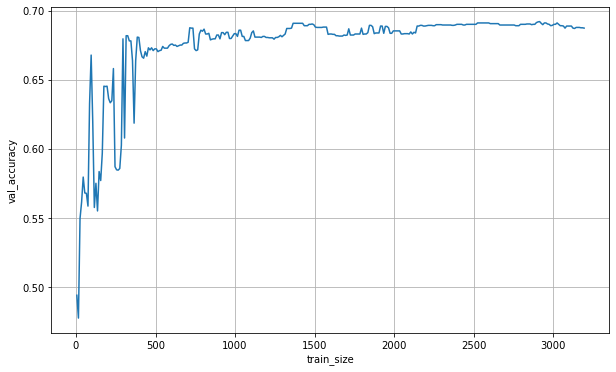

In [35]:
# 이제 그림을 그려봅시다.
# Bias가 줄어드는가? (성능이 향상되는가?)
plt.figure(figsize = (10,6))
plt.plot(tr_size, val_scores_mean)

plt.ylabel('val_accuracy')
plt.xlabel('train_size')
plt.grid()
plt.show()
# 데이터가 늘어나면서, 경향이 꺾여가며 올라가는 것을 알 수 있음
# 저렇게 수평선이 되었을 때 그래프가 갑자기 올라가거나 내려갈 가능성 없음

# 꺾인 구간 500, 1500, 2500 => 그냥 뭐 2500 정도면 충분할 듯

# 그래프가 위아래로 요동치는건
# variance(변동) 데이터가 작을 수록 variance 크다.

### (5) 성능 평가 : Variance가 줄어드는가?

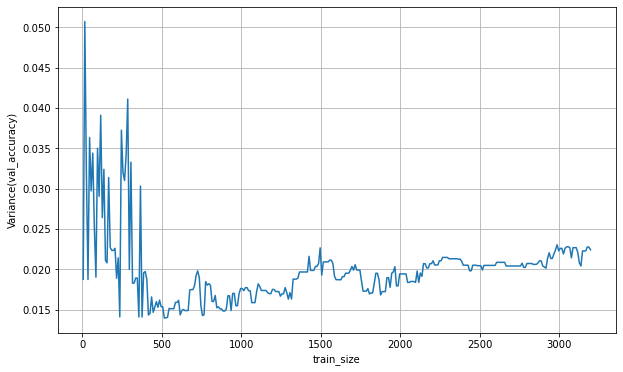

In [36]:
# Variance가 줄어드는가?(성능의 편차가 줄어드는가?)
plt.figure(figsize = (10,6))
plt.plot(tr_size, val_scores_std)

plt.ylabel('Variance(val_accuracy)')
plt.xlabel('train_size')
plt.grid()
plt.show()

# variance를 표로 나타낸 그래프
# 데이터가 적을 때는 막 들쑥날쑥하다가
# 데이터가 많아지니까 좀 줄어드는 것을 알 수 있음.

# 그래서 variance(변동)과 bias(오차) 두 개를 보면서 적정선을 찾는 것이 중요하다.

In [ ]:
# 어느 정도 데이터이면 학습하는데 충분할까요?
